In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot
# all copied from the top cells
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

In [2]:
### pion+
ginuke_pip_hA18 = uproot.open("/Users/lyret/Downloads/pionpAr_hA2018_KE0_2uniform_10M.0.ginuke.root")
ginuke_pip_hN18 = uproot.open("/Users/lyret/Downloads/pionpAr_hN2018_KE0_2uniform_10M.0.ginuke.root")
ginuke_pip_INCL = uproot.open("/Users/lyret/Downloads/pionpAr_INCL_KE0_2uniform_10M.0.ginuke.root")
ginuke_pip_G4BC = uproot.open("/Users/lyret/Downloads/pionpAr_G4BC_KE0_2uniform_10M.0.ginuke.root")
Tree_pip_hA18 = ginuke_pip_hA18["ginuke"]
Tree_pip_hN18 = ginuke_pip_hN18["ginuke"]
Tree_pip_INCL = ginuke_pip_INCL["ginuke"]
Tree_pip_G4BC = ginuke_pip_G4BC["ginuke"]
print("ginuke variables:\n", Tree_pip_hA18.keys())

# load variables to arrays
ginuke_vars_to_load = ["ke", "e", "p", "probe_fsi", "pdgh", "Eh", "ph", "pxh", "pyh", "pzh", "mh", 'np', 'nn', 'npip', 'npim', 'npi0']
vars_pip_hA18 = Tree_pip_hA18.arrays(ginuke_vars_to_load, library="np")
vars_pip_hN18 = Tree_pip_hN18.arrays(ginuke_vars_to_load, library="np")
vars_pip_INCL = Tree_pip_INCL.arrays(ginuke_vars_to_load, library="np")
#vars_pip_G4BC = Tree_pip_G4BC.arrays(ginuke_vars_to_load, library="np")

ginuke variables:
 ['iev', 'probe', 'tgt', 'ke', 'e', 'p', 'A', 'Z', 'vtxx', 'vtxy', 'vtxz', 'probe_fsi', 'dist', 'nh', 'pdgh', 'Eh', 'ph', 'pxh', 'pyh', 'pzh', 'cth', 'mh', 'np', 'nn', 'npip', 'npim', 'npi0']


In [3]:
### edit here to specify model
model = "hA2018"
vars_par = vars_pip_hA18
###

int_type_arr = [] # interaction type
Ereco_arr = [] # energy bias
Etransfer_arr = [] # energy transfer
Pimbalance_arr = [] # momentum imbalance
for ievt in range(len(vars_par["probe_fsi"])):
    pdgh = vars_par["pdgh"][ievt]
    npip = vars_par["npip"][ievt] #np.count_nonzero(pdgh == 211)
    npim = vars_par["npim"][ievt] #np.count_nonzero(pdgh == -211)
    npic = npip + npim
    npi0 = vars_par["npi0"][ievt] #np.count_nonzero(pdgh == 111)
    int_type = 0
    if vars_par["probe_fsi"][ievt] == 1:
        int_type = 0 # no interaction
    elif npic == 1 and npi0 == 0:
        int_type = 1 # quasi-elastic + double charge exchange
    elif npic == 0 and npi0 == 0:
        int_type = 2 # absorption
    elif npic == 0 and npi0 == 1:
        int_type = 3 # charge exchange
    else:
        int_type = 4 # pion production
    int_type_arr.append(int_type)
    
    Eh = vars_par["Eh"][ievt]
    pxh = vars_par["pxh"][ievt]
    pyh = vars_par["pyh"][ievt]
    pzh = vars_par["pzh"][ievt]
    #phsq = pxh*pxh + pyh*pyh + pzh*pzh
    #mh = np.sqrt(Eh*Eh - phsq)
    ph = vars_par["ph"][ievt]
    mh = vars_par["mh"][ievt]
    Ereco_arr.append(cal_Eavail(pdgh, Eh, mh))

    if int_type == 1:
        lead_daughter_idx = np.where(abs(pdgh) == 211)[0]
        Etransfer = vars_par["e"][ievt] - Eh[lead_daughter_idx]
        Etransfer_arr.append(Etransfer)

    daughter_Psum = np.zeros(3)
    for ipar in range(len(pdgh)):
        if (pdgh[ipar] == 2212) and (Eh[ipar] - mh[ipar] > 300):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif (abs(pdgh[ipar]) == 211) and (Eh[ipar] - mh[ipar] > 50):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif pdgh[ipar] == 111:
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
    Pimbalance_vec3 = [daughter_Psum[0], daughter_Psum[1], daughter_Psum[2]-vars_par["p"][ievt]]
    Pimbalance = np.sqrt(np.sum(np.power(Pimbalance_vec3, 2)))
    Pimbalance_arr.append(Pimbalance)
    
int_type_arr = np.array(int_type_arr)
Ereco_arr = np.array(Ereco_arr)
Ebias_arr = Ereco_arr - vars_par["e"] # note "ke" or "e"
Etransfer_arr = np.array(Etransfer_arr)
Pimbalance_arr = np.array(Pimbalance_arr)

##### 0 < KE < 0.25


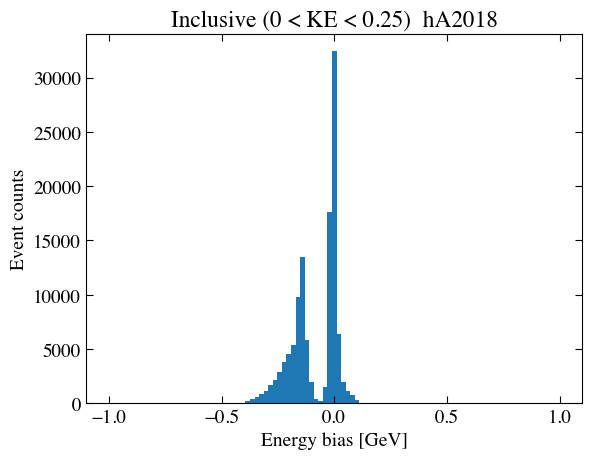

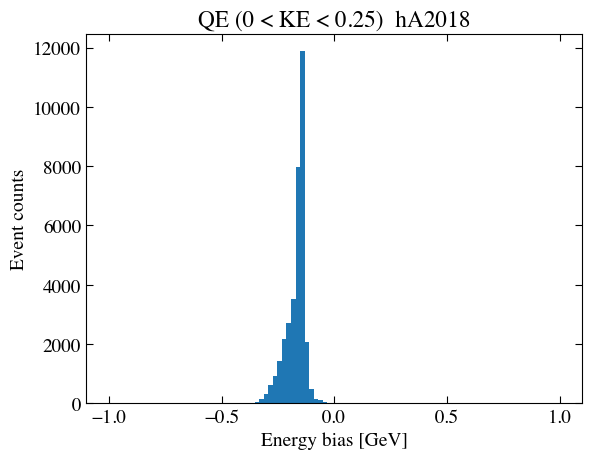

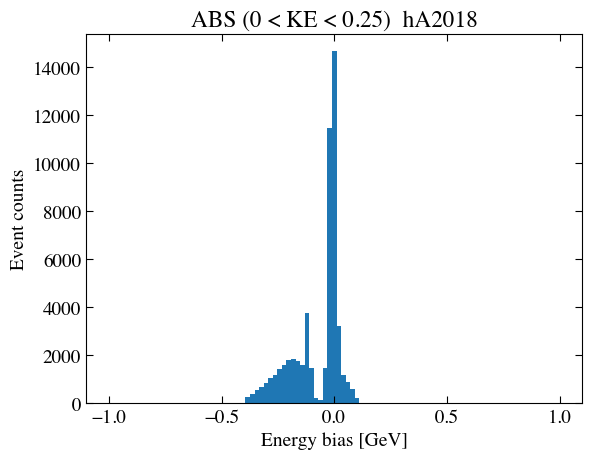

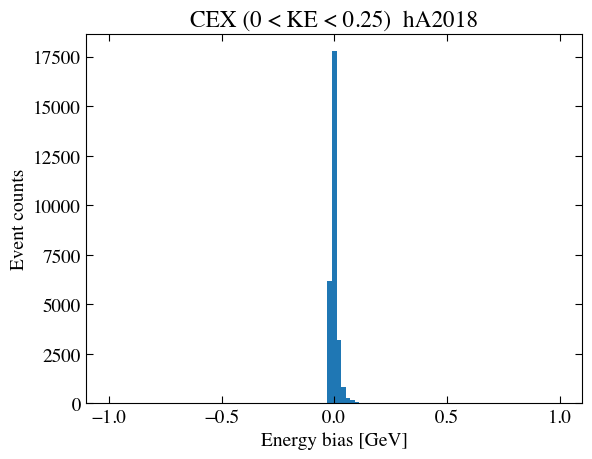

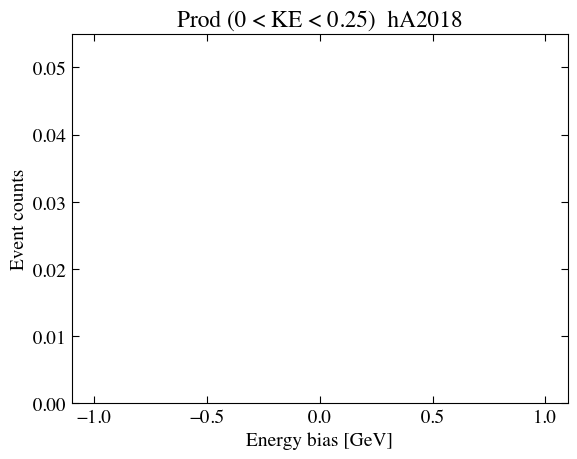

##### 0.25 < KE < 0.5


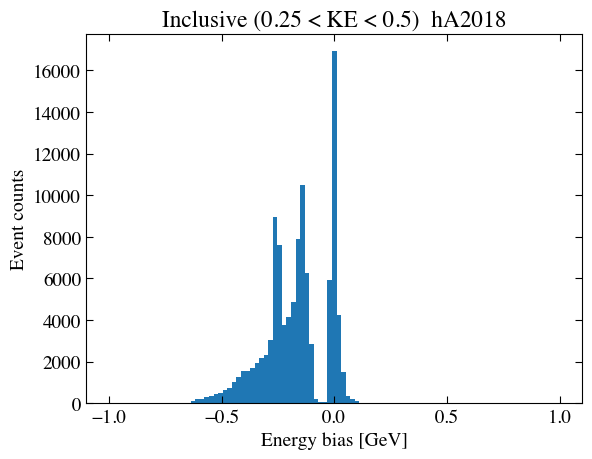

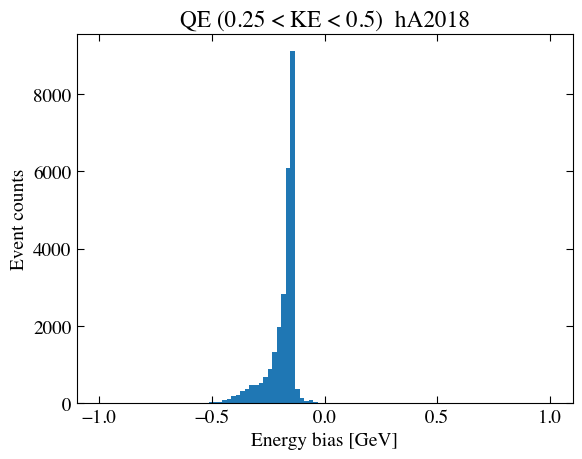

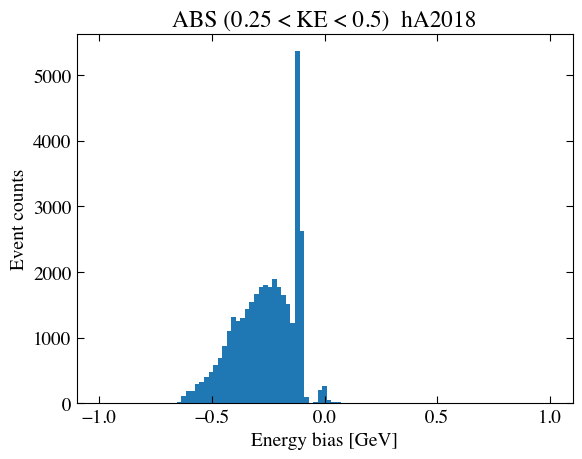

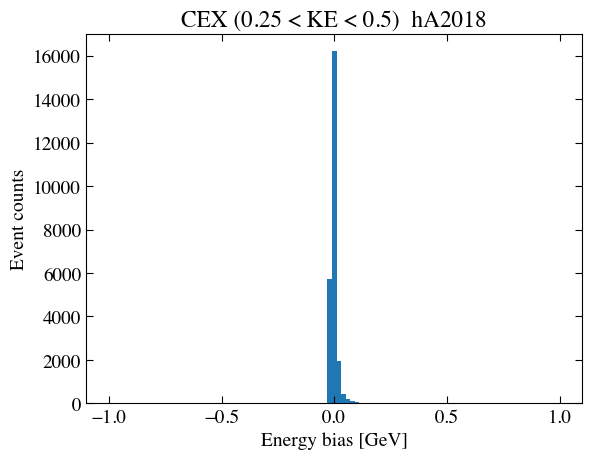

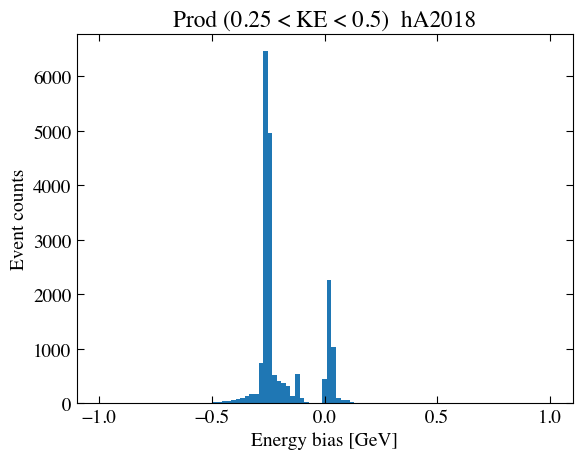

##### 0.5 < KE < 0.75


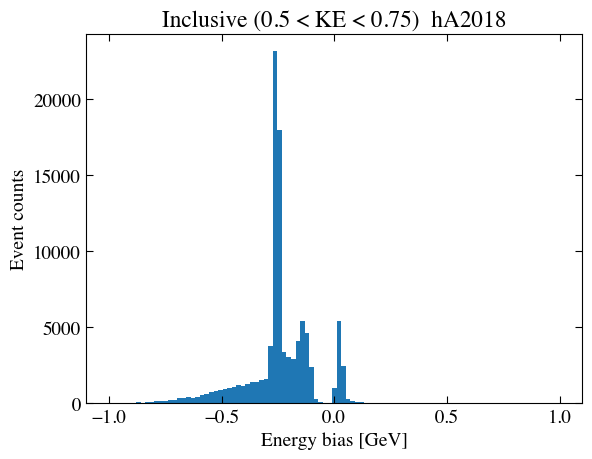

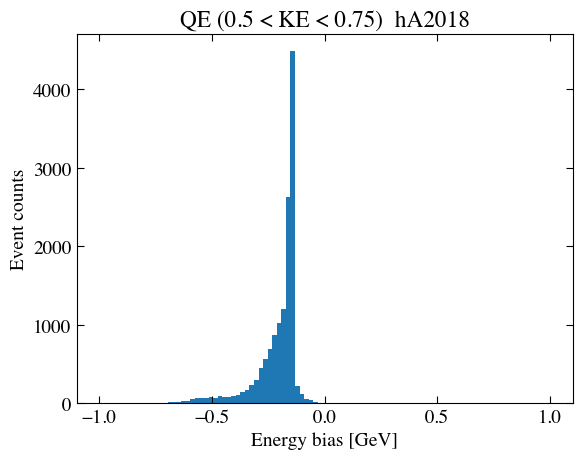

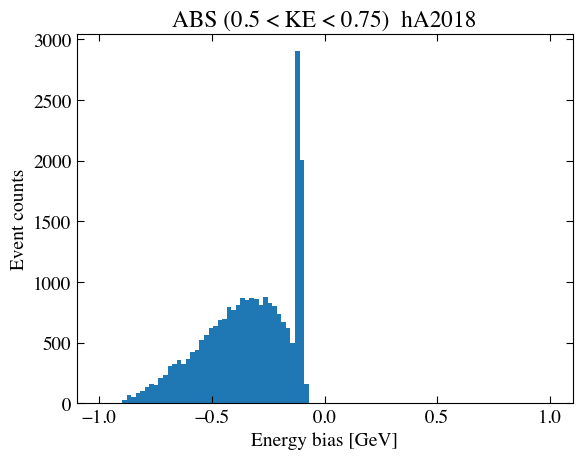

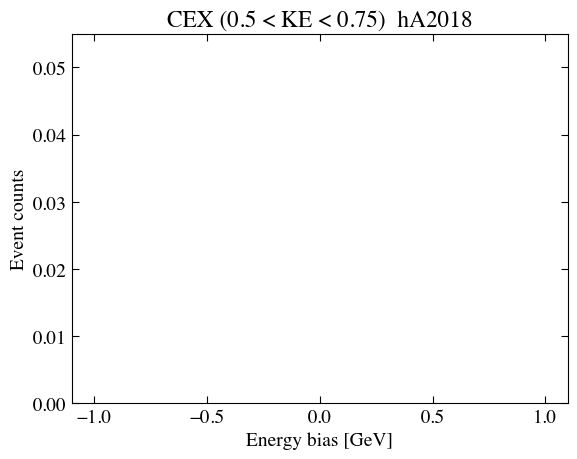

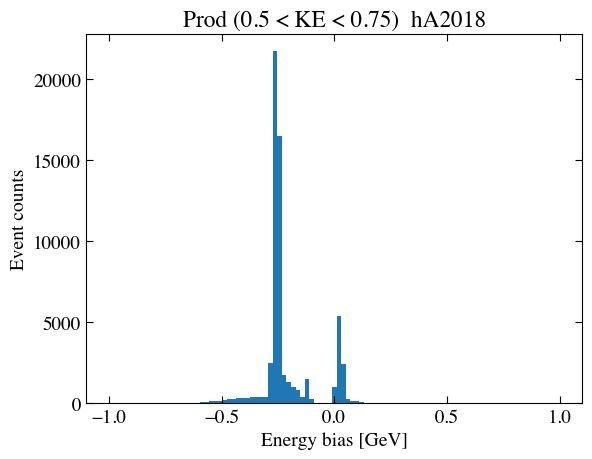

##### 0.75 < KE < 1


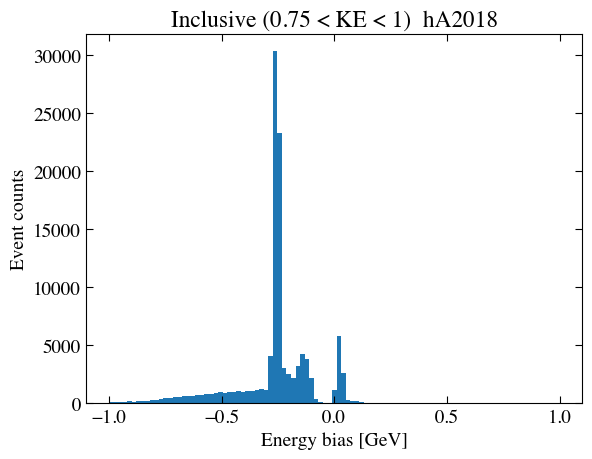

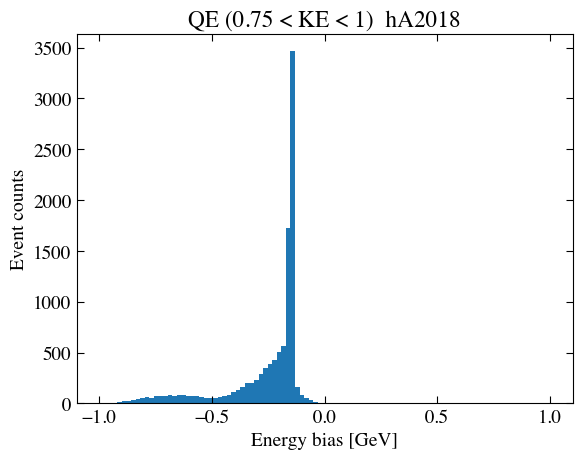

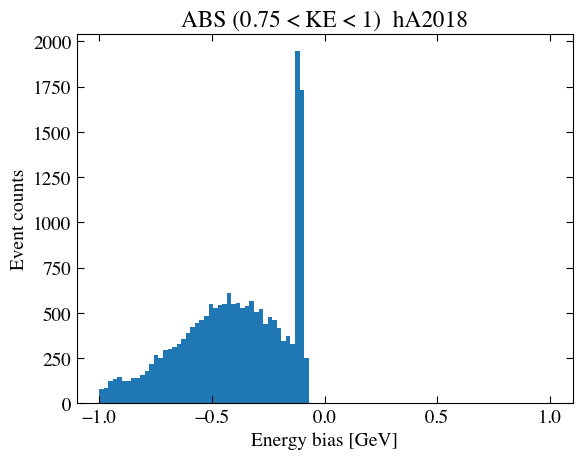

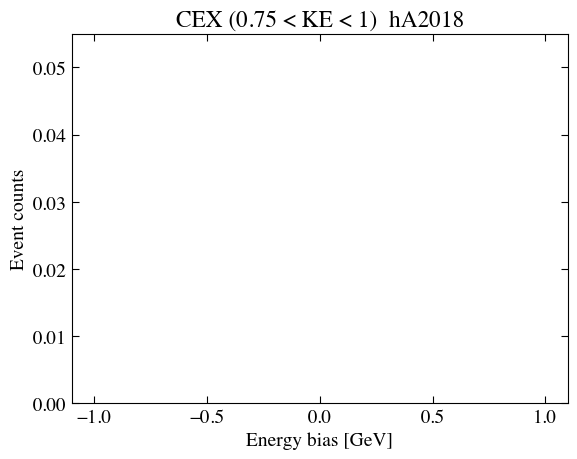

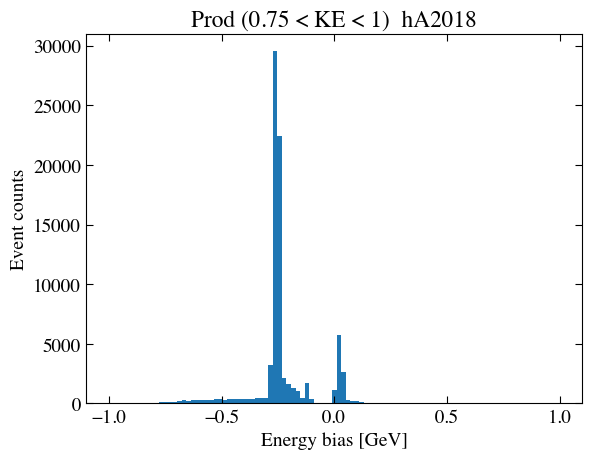

In [4]:
### energy bias plots
xbins = np.linspace(-1, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

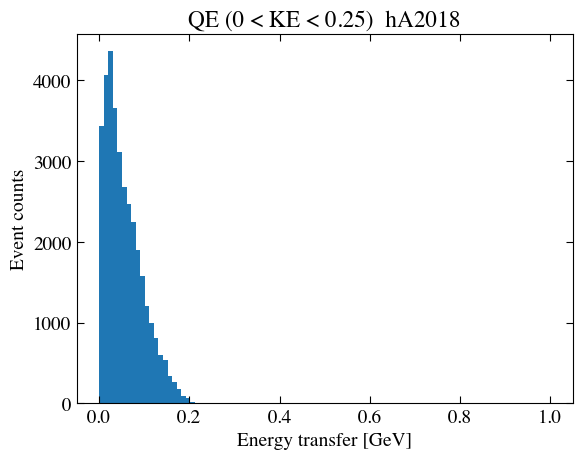

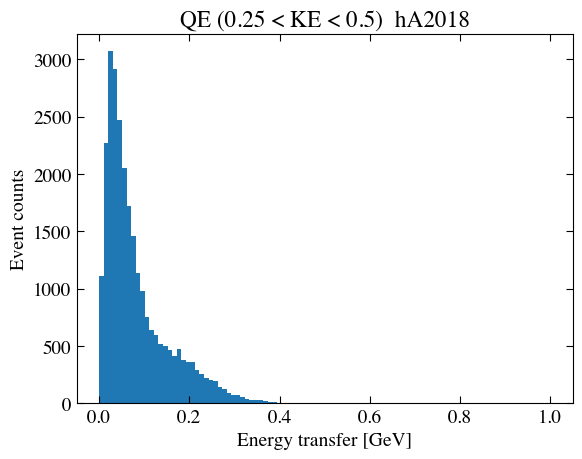

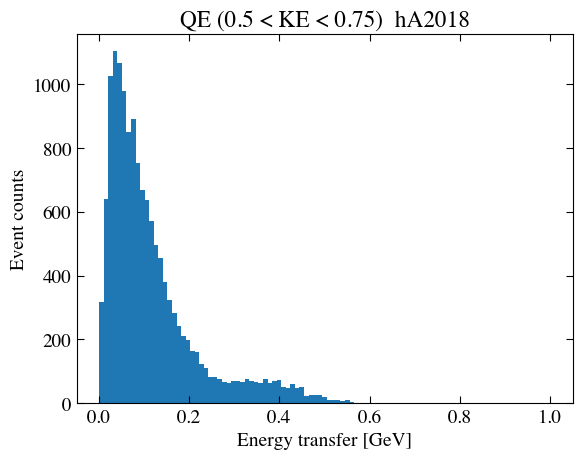

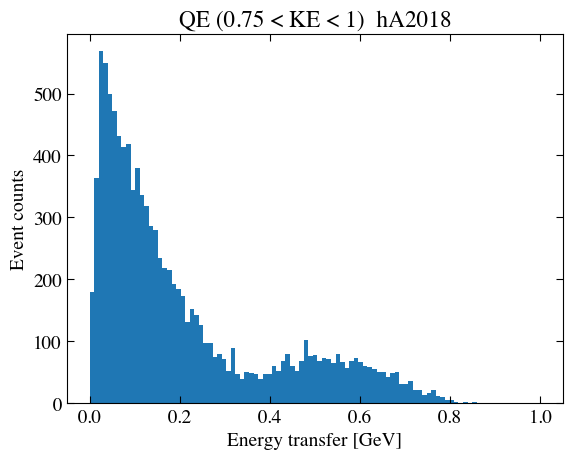

In [5]:
### energy transfer
xbins = np.linspace(0, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

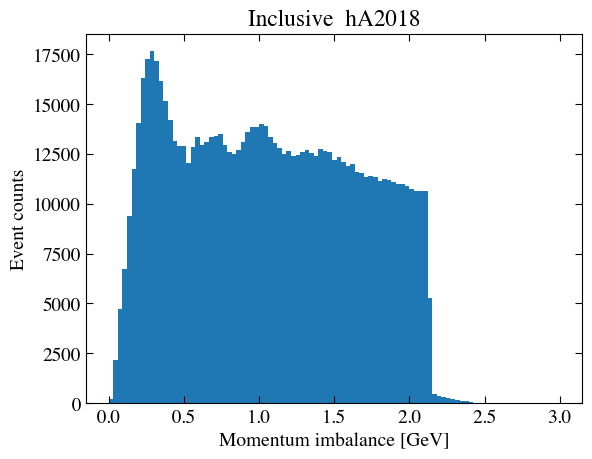

In [6]:
### momentum imbalance
xbins = np.linspace(0, 3, 100)

plt.hist(Pimbalance_arr[int_type_arr>0], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Momentum imbalance [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive  {model}")
plt.show()

In [7]:
### edit here to specify model
model = "hN2018"
vars_par = vars_pip_hN18
###

int_type_arr = [] # interaction type
Ereco_arr = [] # energy bias
Etransfer_arr = [] # energy transfer
Pimbalance_arr = [] # momentum imbalance
for ievt in range(len(vars_par["probe_fsi"])):
    pdgh = vars_par["pdgh"][ievt]
    npip = vars_par["npip"][ievt] #np.count_nonzero(pdgh == 211)
    npim = vars_par["npim"][ievt] #np.count_nonzero(pdgh == -211)
    npic = npip + npim
    npi0 = vars_par["npi0"][ievt] #np.count_nonzero(pdgh == 111)
    int_type = 0
    if vars_par["probe_fsi"][ievt] == 1:
        int_type = 0 # no interaction
    elif npic == 1 and npi0 == 0:
        int_type = 1 # quasi-elastic + double charge exchange
    elif npic == 0 and npi0 == 0:
        int_type = 2 # absorption
    elif npic == 0 and npi0 == 1:
        int_type = 3 # charge exchange
    else:
        int_type = 4 # pion production
    int_type_arr.append(int_type)
    
    Eh = vars_par["Eh"][ievt]
    pxh = vars_par["pxh"][ievt]
    pyh = vars_par["pyh"][ievt]
    pzh = vars_par["pzh"][ievt]
    #phsq = pxh*pxh + pyh*pyh + pzh*pzh
    #mh = np.sqrt(Eh*Eh - phsq)
    ph = vars_par["ph"][ievt]
    mh = vars_par["mh"][ievt]
    Ereco_arr.append(cal_Eavail(pdgh, Eh, mh))

    if int_type == 1:
        lead_daughter_idx = np.where(abs(pdgh) == 211)[0]
        Etransfer = vars_par["e"][ievt] - Eh[lead_daughter_idx]
        Etransfer_arr.append(Etransfer)

    daughter_Psum = np.zeros(3)
    for ipar in range(len(pdgh)):
        if (pdgh[ipar] == 2212) and (Eh[ipar] - mh[ipar] > 300):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif (abs(pdgh[ipar]) == 211) and (Eh[ipar] - mh[ipar] > 50):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif pdgh[ipar] == 111:
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
    Pimbalance_vec3 = [daughter_Psum[0], daughter_Psum[1], daughter_Psum[2]-vars_par["p"][ievt]]
    Pimbalance = np.sqrt(np.sum(np.power(Pimbalance_vec3, 2)))
    Pimbalance_arr.append(Pimbalance)
    
int_type_arr = np.array(int_type_arr)
Ereco_arr = np.array(Ereco_arr)
Ebias_arr = Ereco_arr - vars_par["e"] # note "ke" or "e"
Etransfer_arr = np.array(Etransfer_arr)
Pimbalance_arr = np.array(Pimbalance_arr)

##### 0 < KE < 0.25


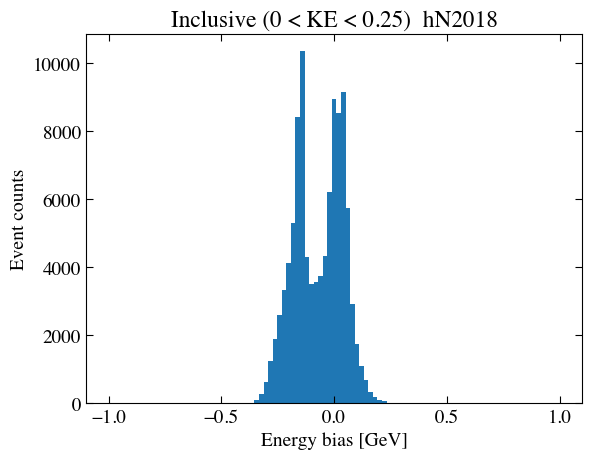

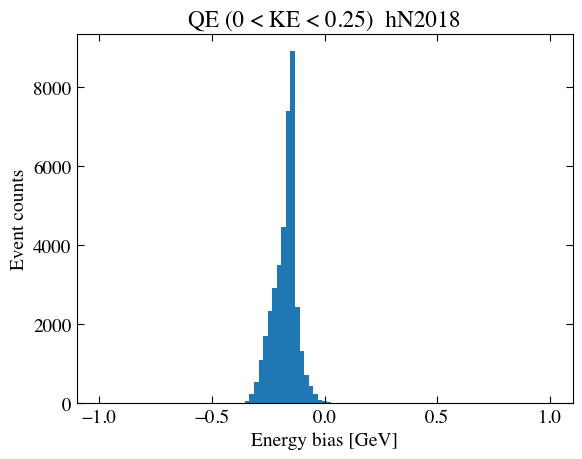

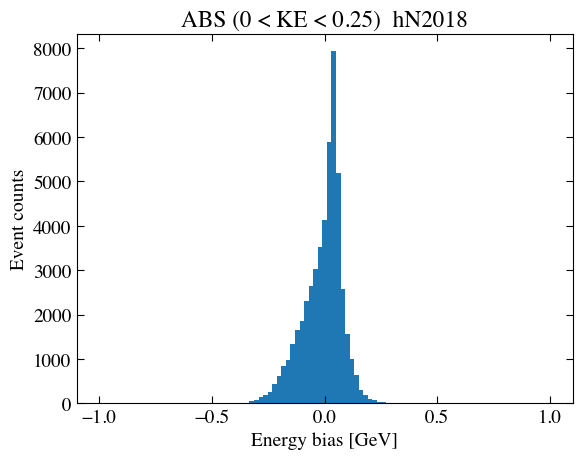

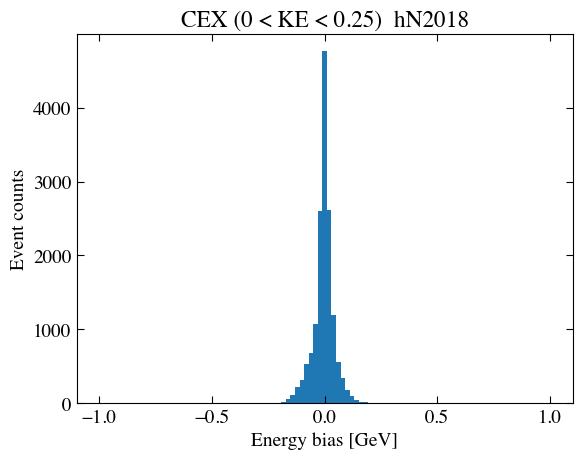

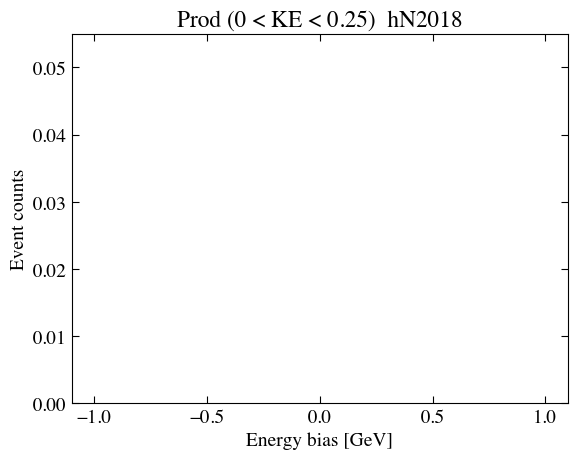

##### 0.25 < KE < 0.5


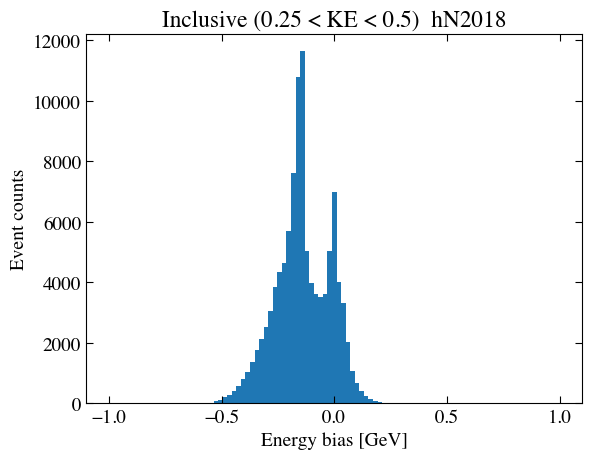

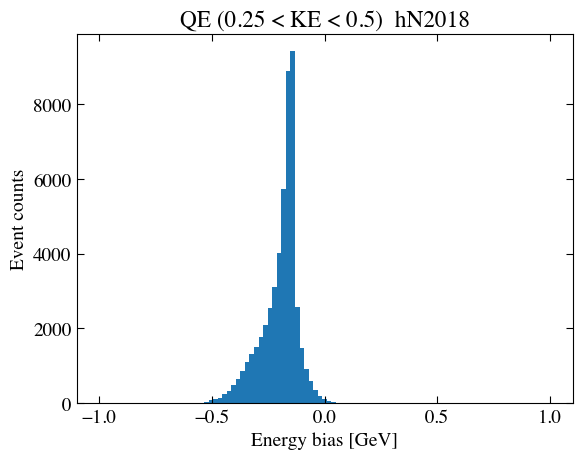

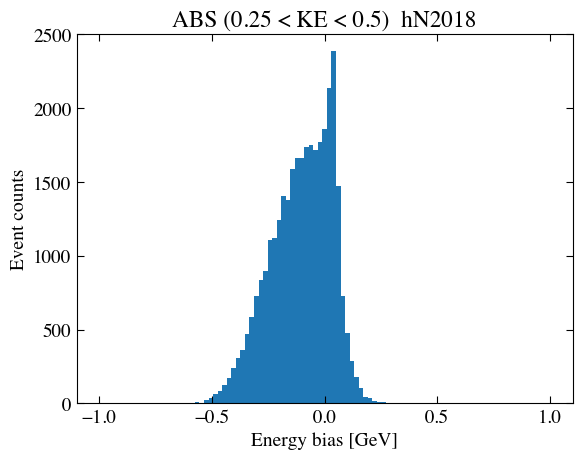

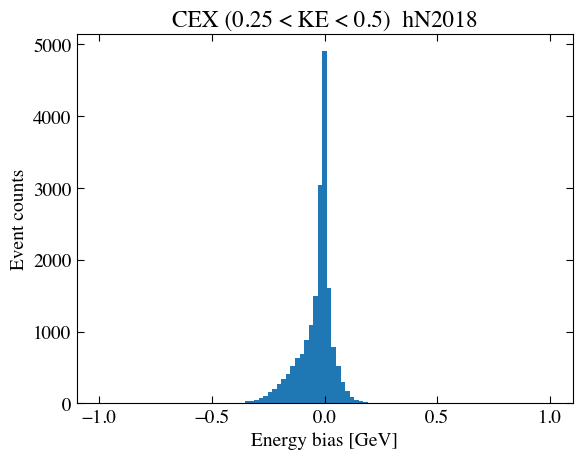

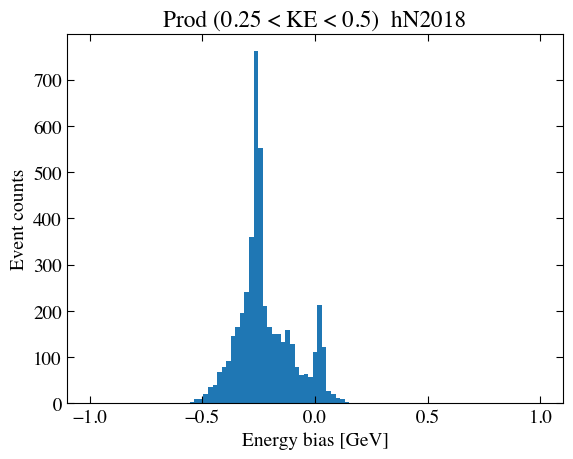

##### 0.5 < KE < 0.75


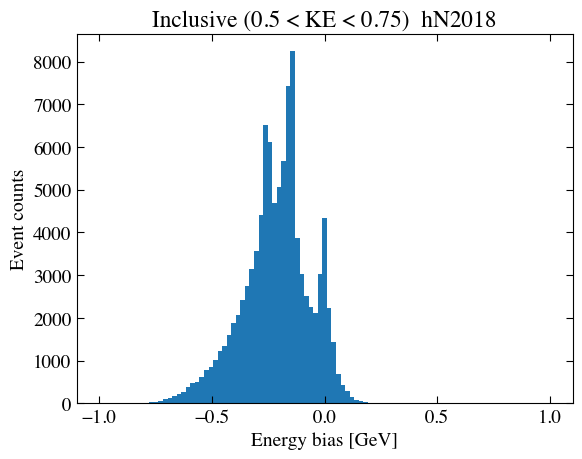

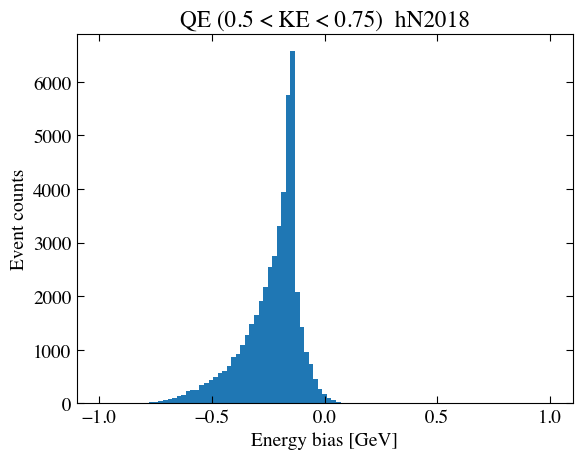

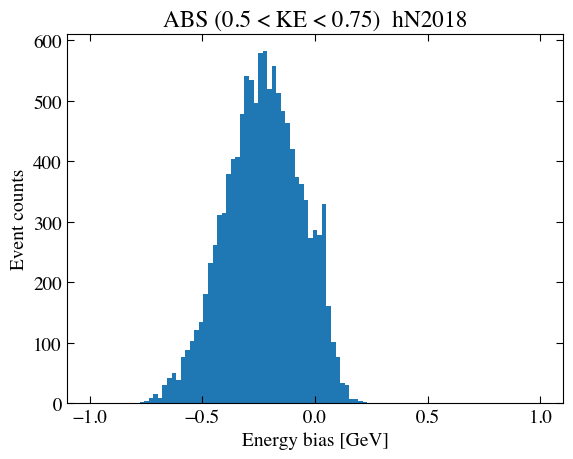

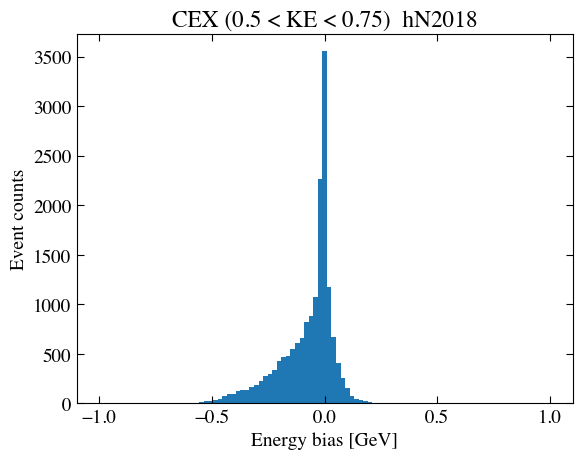

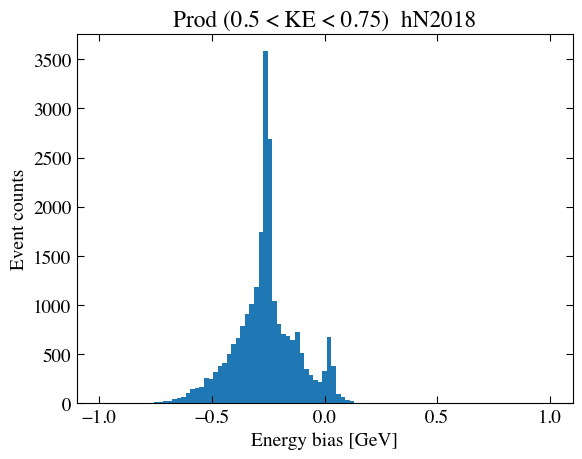

##### 0.75 < KE < 1


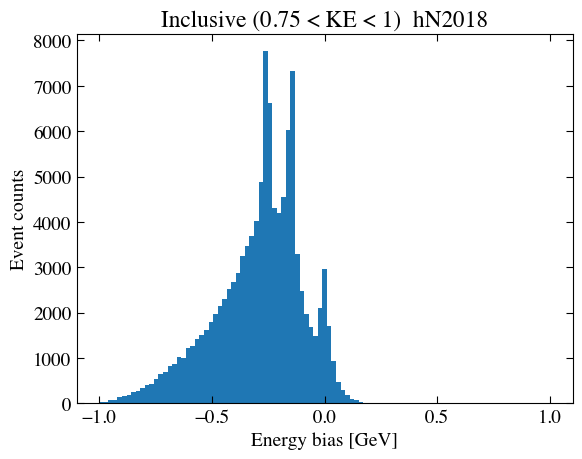

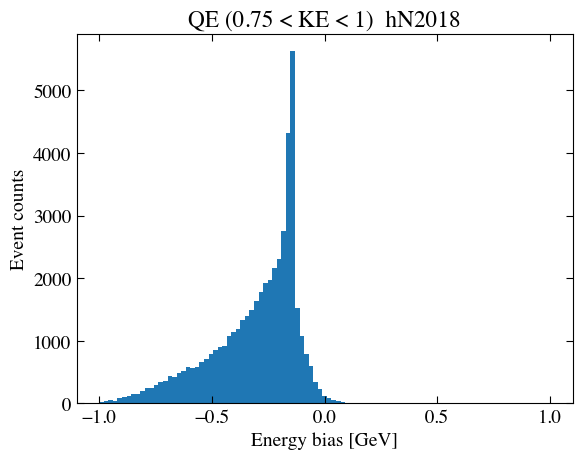

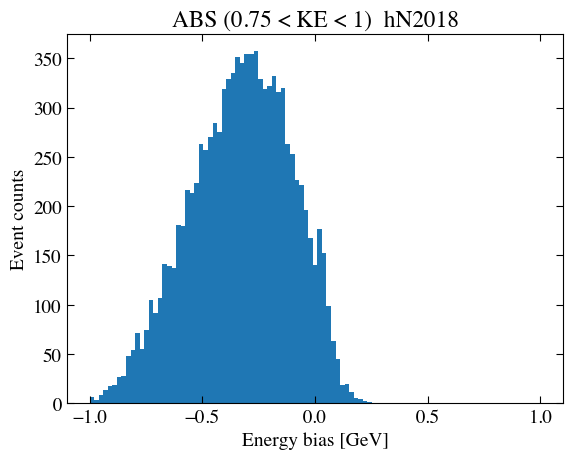

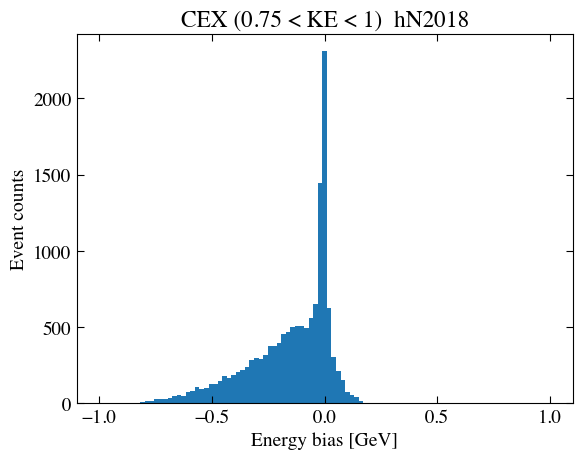

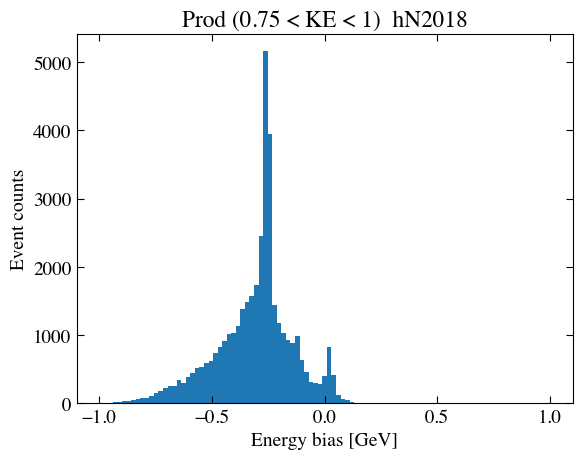

In [8]:
### energy bias plots
xbins = np.linspace(-1, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

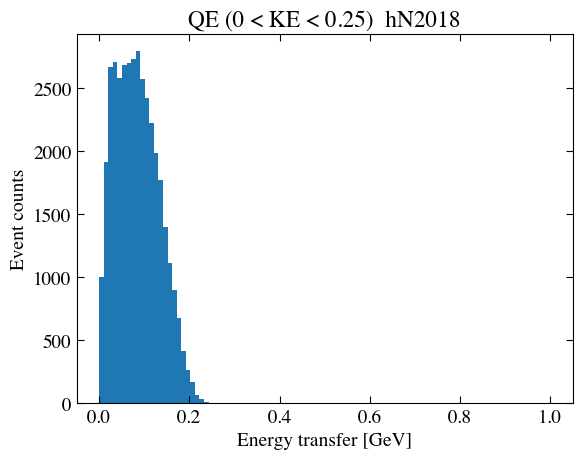

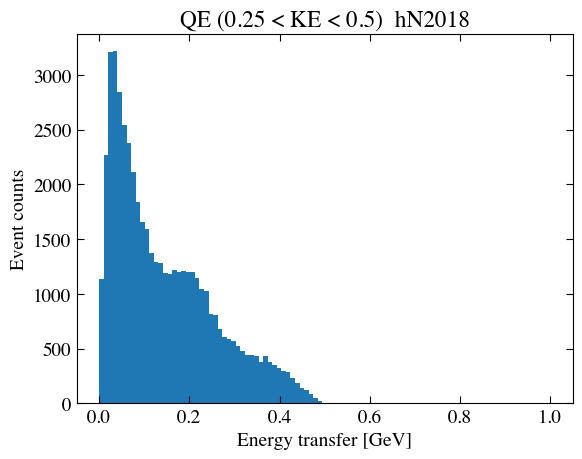

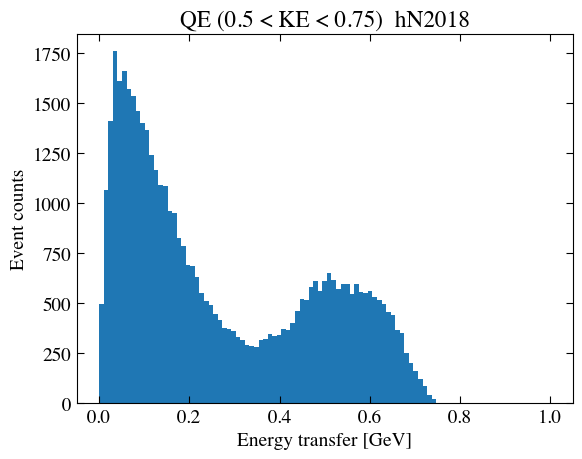

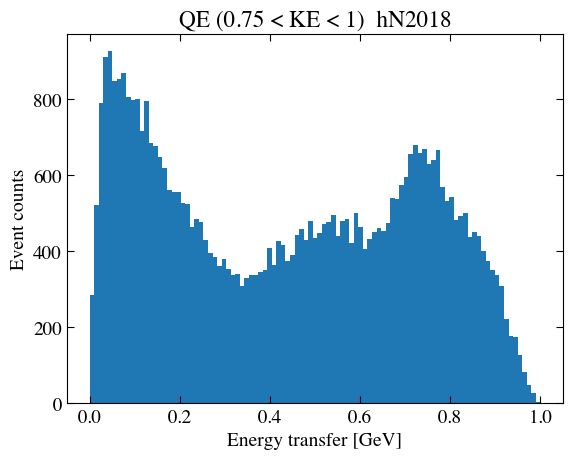

In [9]:
### energy transfer
xbins = np.linspace(0, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

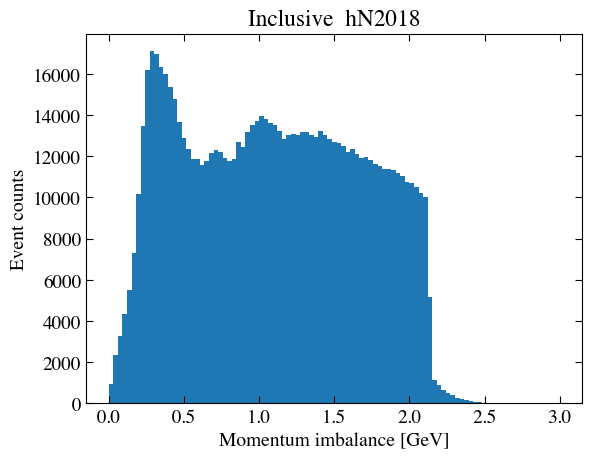

In [10]:
### momentum imbalance
xbins = np.linspace(0, 3, 100)

plt.hist(Pimbalance_arr[int_type_arr>0], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Momentum imbalance [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive  {model}")
plt.show()

In [11]:
### edit here to specify model
model = "INCL"
vars_par = vars_pip_INCL
###

int_type_arr = [] # interaction type
Ereco_arr = [] # energy bias
Etransfer_arr = [] # energy transfer
Pimbalance_arr = [] # momentum imbalance
for ievt in range(len(vars_par["probe_fsi"])):
    pdgh = vars_par["pdgh"][ievt]
    npip = vars_par["npip"][ievt] #np.count_nonzero(pdgh == 211)
    npim = vars_par["npim"][ievt] #np.count_nonzero(pdgh == -211)
    npic = npip + npim
    npi0 = vars_par["npi0"][ievt] #np.count_nonzero(pdgh == 111)
    int_type = 0
    if vars_par["probe_fsi"][ievt] == 1:
        int_type = 0 # no interaction
    elif npic == 1 and npi0 == 0:
        int_type = 1 # quasi-elastic + double charge exchange
    elif npic == 0 and npi0 == 0:
        int_type = 2 # absorption
    elif npic == 0 and npi0 == 1:
        int_type = 3 # charge exchange
    else:
        int_type = 4 # pion production
    int_type_arr.append(int_type)
    
    Eh = vars_par["Eh"][ievt]
    pxh = vars_par["pxh"][ievt]
    pyh = vars_par["pyh"][ievt]
    pzh = vars_par["pzh"][ievt]
    #phsq = pxh*pxh + pyh*pyh + pzh*pzh
    #mh = np.sqrt(Eh*Eh - phsq)
    ph = vars_par["ph"][ievt]
    mh = vars_par["mh"][ievt]
    Ereco_arr.append(cal_Eavail(pdgh, Eh, mh))

    if int_type == 1:
        lead_daughter_idx = np.where(abs(pdgh) == 211)[0]
        Etransfer = vars_par["e"][ievt] - Eh[lead_daughter_idx]
        Etransfer_arr.append(Etransfer)

    daughter_Psum = np.zeros(3)
    for ipar in range(len(pdgh)):
        if (pdgh[ipar] == 2212) and (Eh[ipar] - mh[ipar] > 300):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif (abs(pdgh[ipar]) == 211) and (Eh[ipar] - mh[ipar] > 50):
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
        elif pdgh[ipar] == 111:
            daughter_Psum += [pxh[ipar], pyh[ipar], pzh[ipar]]
    Pimbalance_vec3 = [daughter_Psum[0], daughter_Psum[1], daughter_Psum[2]-vars_par["p"][ievt]]
    Pimbalance = np.sqrt(np.sum(np.power(Pimbalance_vec3, 2)))
    Pimbalance_arr.append(Pimbalance)
    
int_type_arr = np.array(int_type_arr)
Ereco_arr = np.array(Ereco_arr)
Ebias_arr = Ereco_arr - vars_par["e"] # note "ke" or "e"
Etransfer_arr = np.array(Etransfer_arr)
Pimbalance_arr = np.array(Pimbalance_arr)

##### 0 < KE < 0.25


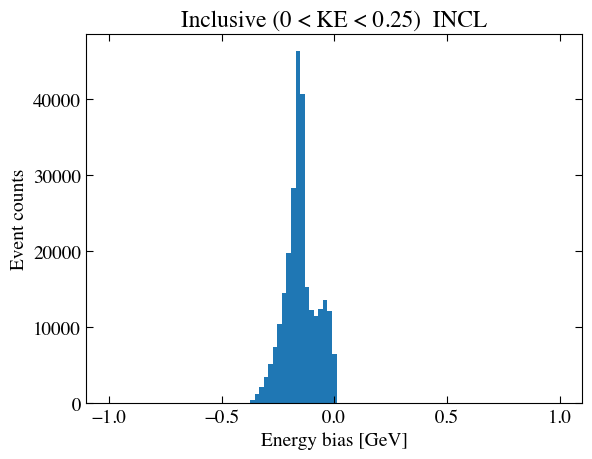

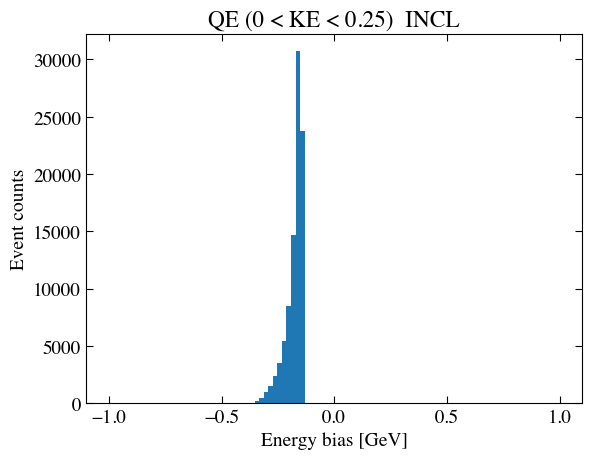

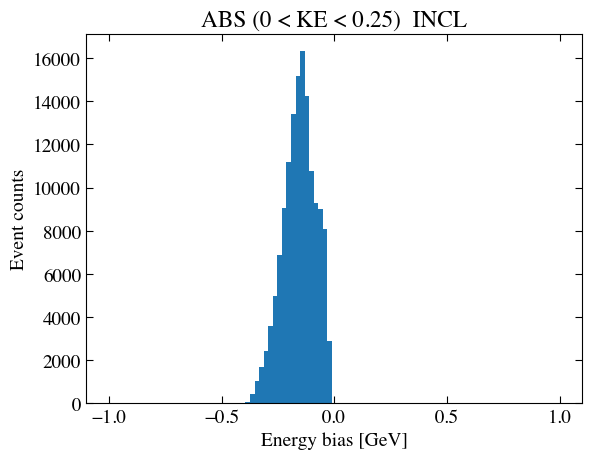

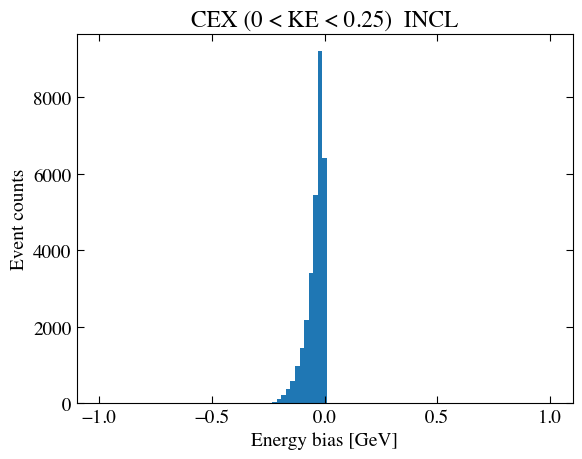

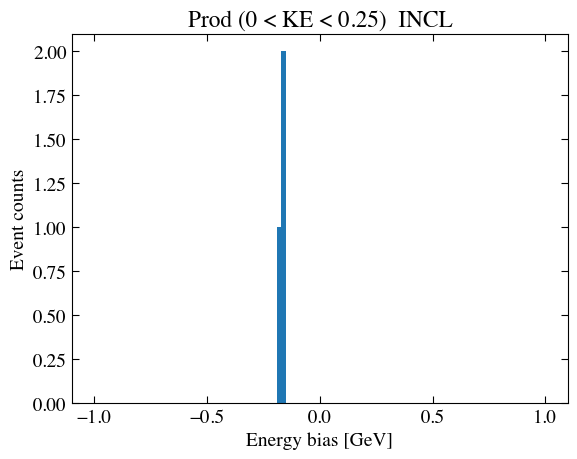

##### 0.25 < KE < 0.5


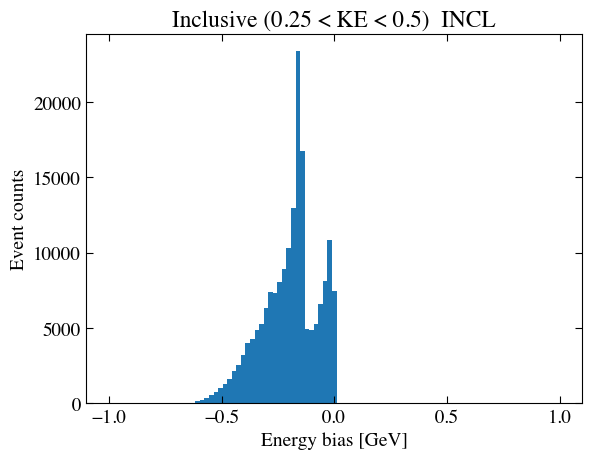

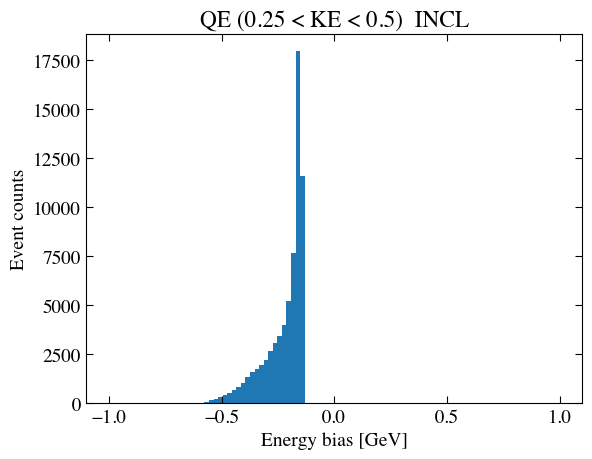

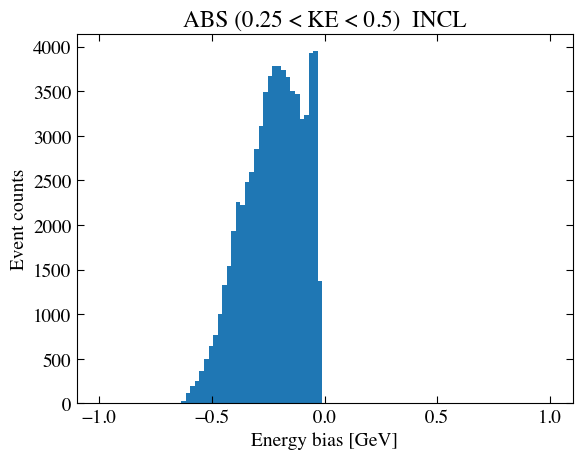

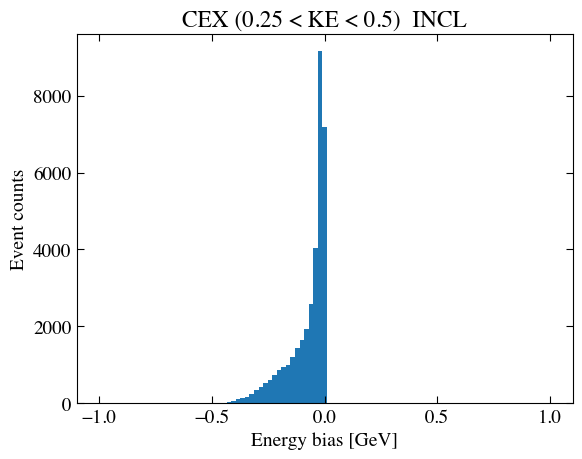

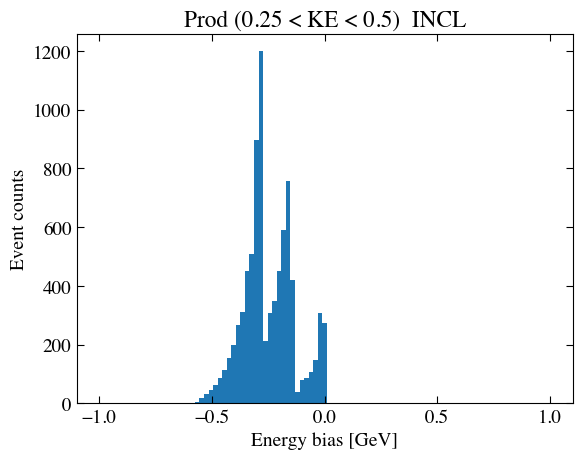

##### 0.5 < KE < 0.75


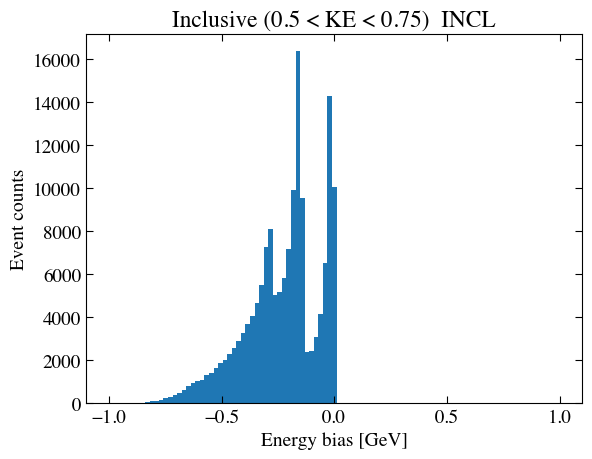

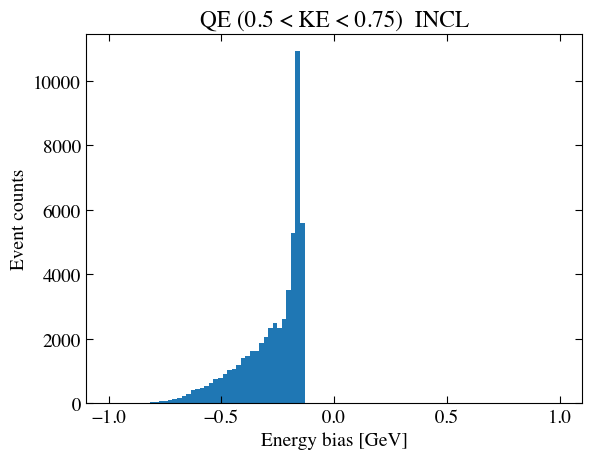

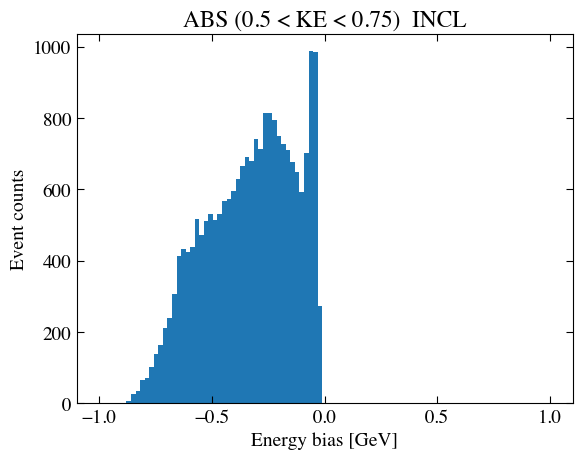

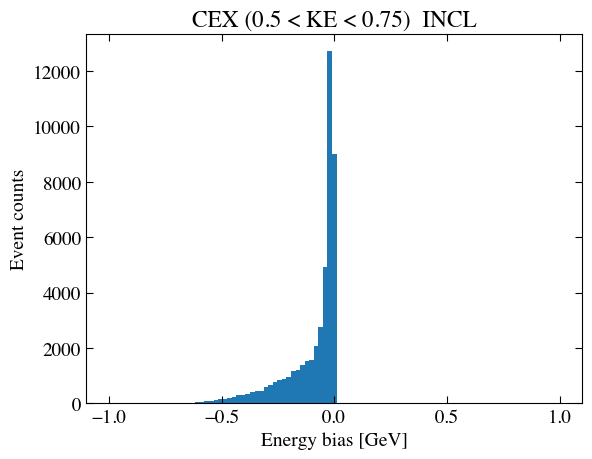

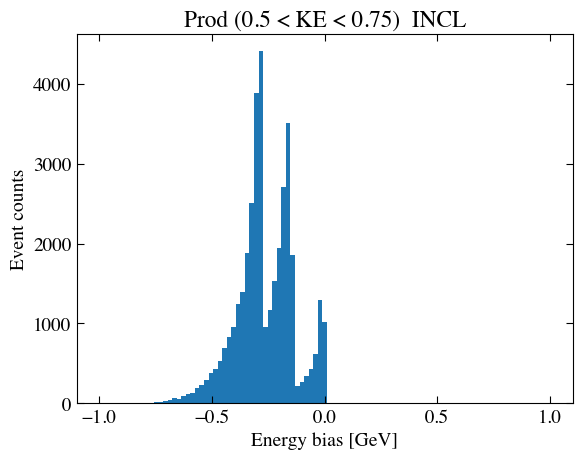

##### 0.75 < KE < 1


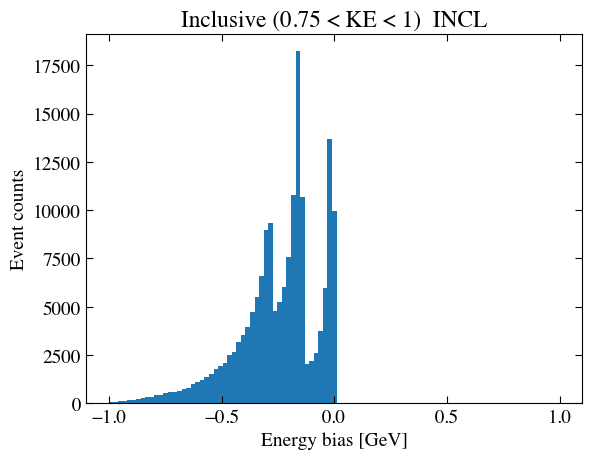

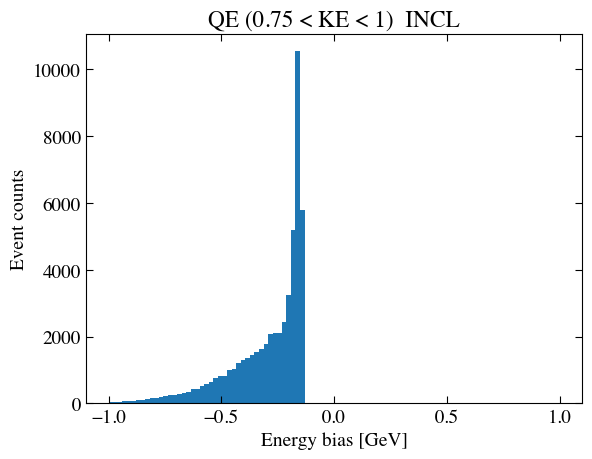

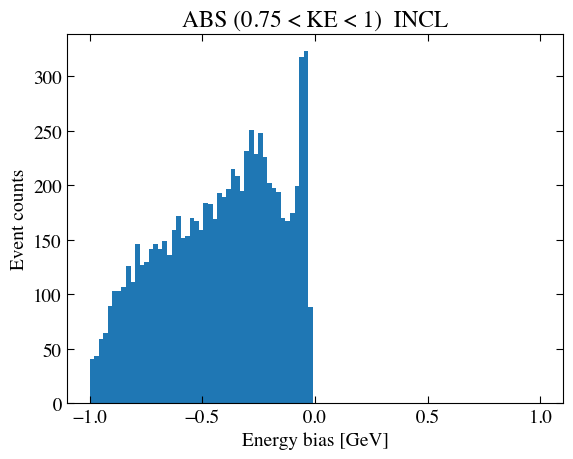

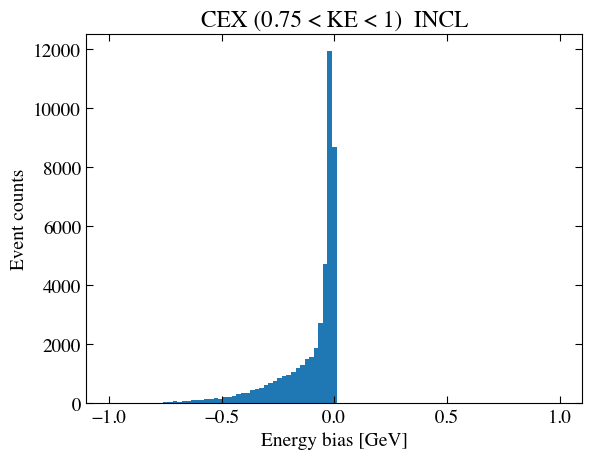

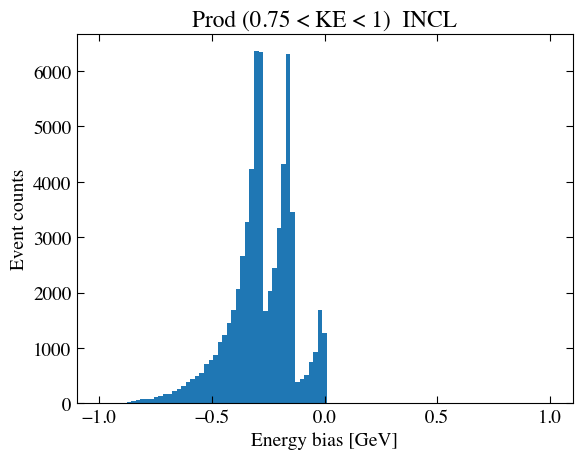

In [12]:
### energy bias plots
xbins = np.linspace(-1, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()


KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
print(f"##### {KEi_min} < KE < {KEi_max}")
plt.hist(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==1)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"ABS ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==3)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"CEX ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

plt.hist(Ebias_arr[mask & (int_type_arr==4)], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Prod ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

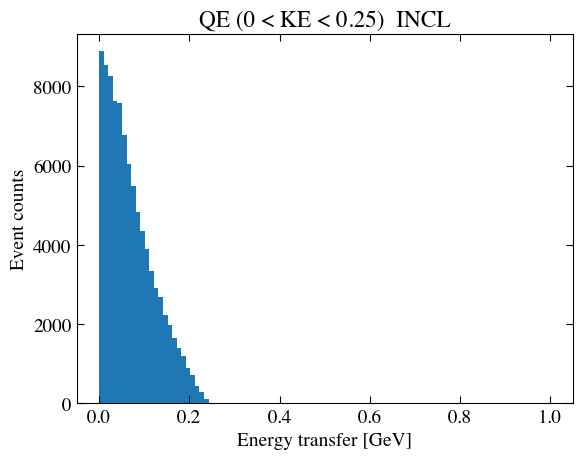

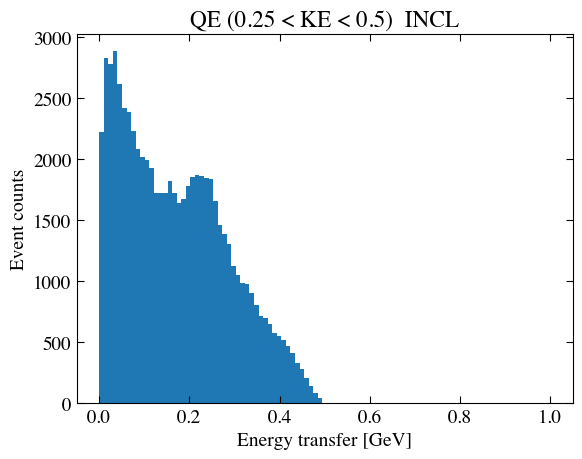

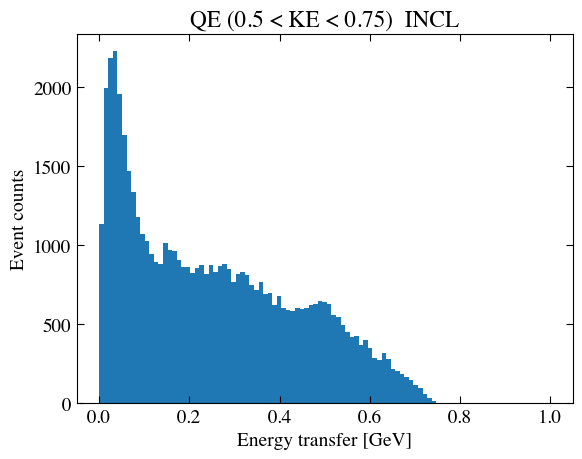

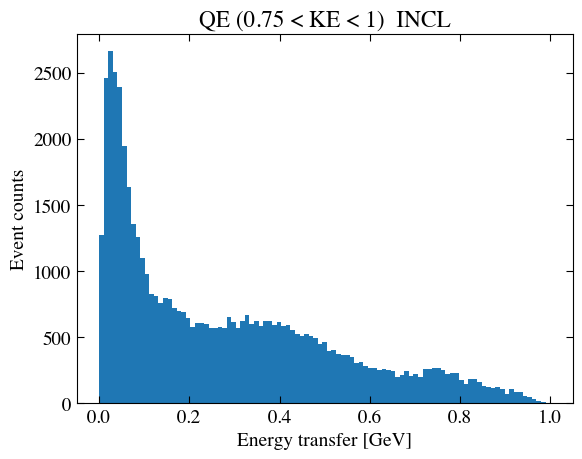

In [13]:
### energy transfer
xbins = np.linspace(0, 1, 100)
KEmask = [0, 0.25, 0.5, 0.75, 1] # GeV

KEi_min = 0; KEi_max = 0.25 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.25; KEi_max = 0.5 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.5; KEi_max = 0.75 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

KEi_min = 0.75; KEi_max = 1 # edit here
mask = (vars_par["ke"] > KEi_min) & (vars_par["ke"] < KEi_max)
plt.hist(Etransfer_arr[mask[int_type_arr==1]], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Energy transfer [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"QE ({KEi_min} < KE < {KEi_max})  {model}")
plt.show()

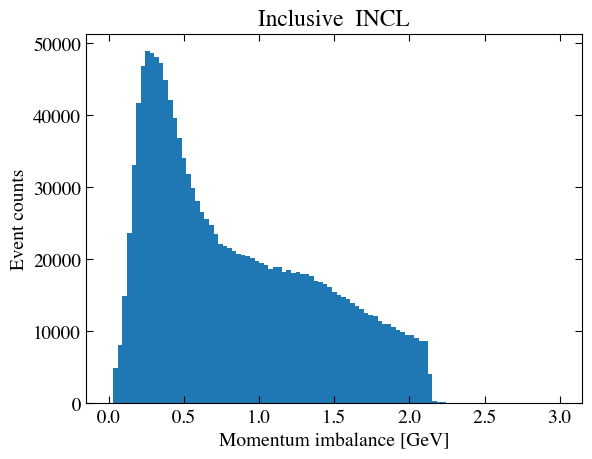

In [14]:
### momentum imbalance
xbins = np.linspace(0, 3, 100)

plt.hist(Pimbalance_arr[int_type_arr>0], bins=xbins)
plt.xlim(None, None)
plt.xlabel("Momentum imbalance [GeV]")
plt.ylim(0, None)
plt.ylabel("Event counts")
plt.title(f"Inclusive  {model}")
plt.show()

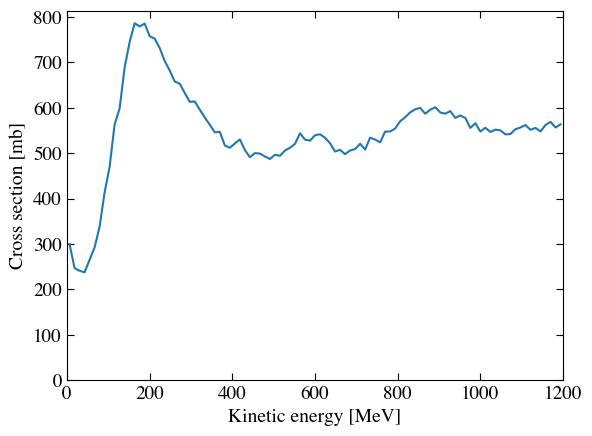

In [3]:
A = 40
r0 = 3*1.4
r = r0*(A**(1./3.))
scale_factor = 10*np.pi * r*r

KEbins = np.linspace(0, 1.2, 100)

# total inelastic
Nincident, _ = np.histogram(vars_pip_hN18["ke"], bins=KEbins)
Ninteract, _ = np.histogram(vars_pip_hN18["ke"][vars_pip_hN18["probe_fsi"]>1], bins=KEbins)
plt.plot(1000*(KEbins[1:]+KEbins[:-1])/2, scale_factor*Ninteract/Nincident)
plt.xlim(0, 1200)
plt.xlabel("Kinetic energy [MeV]")
plt.ylim(0, None)
plt.ylabel("Cross section [mb]")
plt.show()

In [4]:
# interaction type
int_type_arr = []
for ievt in range(len(vars_pip_hN18["probe_fsi"])):
    pdgh = vars_pip_hN18["pdgh"][ievt]
    npip = np.count_nonzero(pdgh == 211)
    npim = np.count_nonzero(pdgh == -211)
    npic = npip + npim
    npi0 = np.count_nonzero(pdgh == 111)
    if vars_pip_hN18["probe_fsi"][ievt] == 1:
        int_type_arr.append(0) # no interaction
    elif npic == 1 and npi0 == 0:
        int_type_arr.append(1) # quasi-elastic + double charge exchange
    elif npic == 0 and npi0 == 0:
        int_type_arr.append(2) # absorption
    elif npic == 0 and npi0 == 1:
        int_type_arr.append(3) # charge exchange
    else:
        int_type_arr.append(4) # pion production
int_type_arr = np.array(int_type_arr)

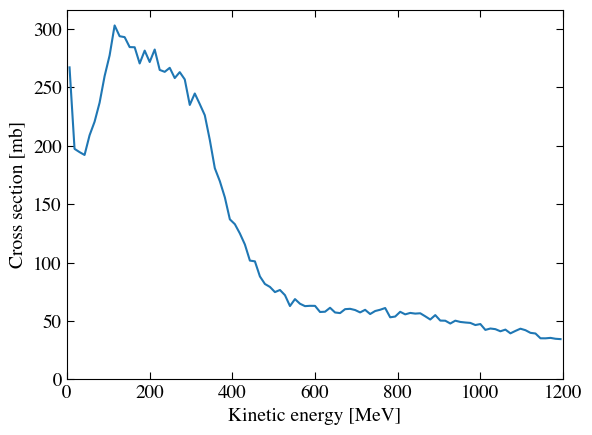

In [5]:
# exclusive
Ninteract, _ = np.histogram(vars_pip_hN18["ke"][int_type_arr==2], bins=KEbins) # indicate here int_type_arr==?
plt.plot(1000*(KEbins[1:]+KEbins[:-1])/2, scale_factor*Ninteract/Nincident)
plt.xlim(0, 1200)
plt.xlabel("Kinetic energy [MeV]")
plt.ylim(0, None)
plt.ylabel("Cross section [mb]")
plt.show()

In [6]:
# energy bias
Ereco_arr = []
for ievt in range(len(vars_pip_hN18["probe_fsi"])):
    pdgh = vars_pip_hN18["pdgh"][ievt]
    Eh = vars_pip_hN18["Eh"][ievt]
    pxh = vars_pip_hN18["pxh"][ievt]
    pyh = vars_pip_hN18["pyh"][ievt]
    pzh = vars_pip_hN18["pzh"][ievt]
    phsq = pxh*pxh + pyh*pyh + pzh*pzh
    mh = np.sqrt(Eh*Eh - phsq)
    Ereco_arr.append(cal_Eavail(pdgh, Eh, mh))
Ereco_arr = np.array(Ereco_arr)
Ebias_arr = Ereco_arr - vars_pip_hN18["e"] # note "ke" or "e"

[-0.13957018 -0.13957018 -0.13957018 ... -0.13957018 -0.13957018
 -0.00841914]
[      0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       5       3      22      24      76     125     207     272
     422     585     805    1045    1395    1860    2414    3139    4288
    5753    6936    7992    9813   12934   19231 2307698    9336    7465
    7162    7248    7963   11278   15927   12537   12463    7780    3984
    2409    1479     920     460     261     150     102      39      33
      17      13       5       4       2       3       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0]
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0  

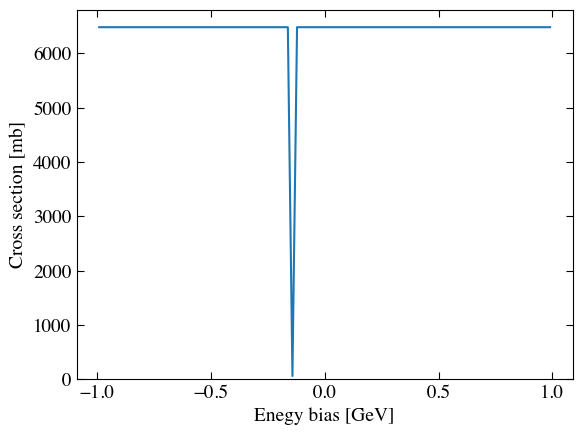

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 7.0000e+00, 5.0000e+00, 2.1000e+01, 3.8000e+01,
        6.0000e+01, 8.3000e+01, 1.2100e+02, 1.7400e+02, 2.3800e+02,
        3.0400e+02, 3.6500e+02, 4.8300e+02, 6.3100e+02, 8.0200e+02,
        9.8800e+02, 1.0960e+03, 1.3550e+03, 1.5530e+03, 1.8630e+03,
        2.2530e+03, 2.3560e+03, 2.9180e+03, 3.3020e+03, 3.5270e+03,
        4.0340e+03, 4.3870e+03, 4.7460e+03, 5.2950e+03, 5.9870e+03,
        8.0100e+03, 1.0312e+04, 6.6580e+03, 3.3030e+03, 2.0330e+03,
        1.2750e+03, 8.1200e+02, 4.0700e+02, 2.2800e+02, 1.3400e+02,
        8.9000e+01, 3.3000e+01, 2.9000e+01, 1.3000e+01, 9.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

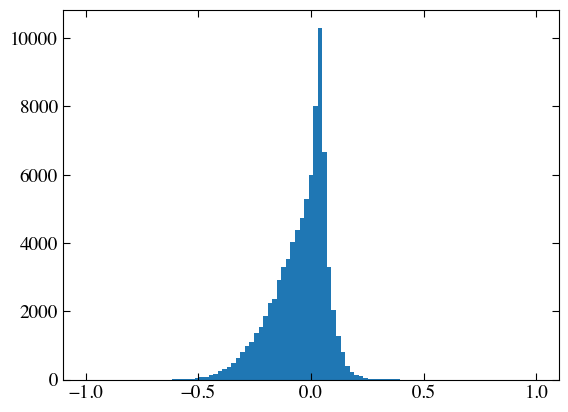

In [9]:
print(Ebias_arr[Ebias_arr!=0])
xbins = np.linspace(-1, 1, 100)
mask = (vars_pip_hN18["ke"] < 0.5) # (GeV) energy mask
Nincident, _ = np.histogram(Ebias_arr[mask], bins=xbins)
Ninteract, _ = np.histogram(Ebias_arr[mask & (int_type_arr>0)], bins=xbins)
print(Nincident, Ninteract, sep="\n")
plt.plot((xbins[1:]+xbins[:-1])/2, scale_factor*safe_divide(Ninteract, Nincident, 0))
plt.xlim(None, None)
plt.xlabel("Enegy bias [GeV]")
plt.ylim(0, None)
plt.ylabel("Cross section [mb]")
plt.show()
plt.hist(Ebias_arr[mask & (int_type_arr==2)], bins=xbins)

In [2]:
### proton
ginuke_p_hA18 = uproot.open("/Users/lyret/Downloads/protonAr_hA2018_KE0_2uniform_10M.0.ginuke.root")
ginuke_p_hN18 = uproot.open("/Users/lyret/Downloads/protonAr_hN2018_KE0_2uniform_10M.0.ginuke.root")
ginuke_p_INCL = uproot.open("/Users/lyret/Downloads/protonAr_INCL_KE0_2uniform_10M.0.ginuke.root")
ginuke_p_G4BC = uproot.open("/Users/lyret/Downloads/protonAr_G4BC_KE0_2uniform_10M.0.ginuke.root")
Tree_p_hA18 = ginuke_p_hA18["ginuke"]
Tree_p_hN18 = ginuke_p_hN18["ginuke"]
Tree_p_INCL = ginuke_p_INCL["ginuke"]
Tree_p_G4BC = ginuke_p_G4BC["ginuke"]
print("ginuke variables:\n", Tree_p_hA18.keys())

# load variables to arrays
ginuke_vars_to_load = ["ke", "e", "probe_fsi", "pdgh", "Eh", "pxh", "pyh", "pzh"]
vars_p_hA18 = Tree_p_hA18.arrays(ginuke_vars_to_load, library="np")
vars_p_hN18 = Tree_p_hN18.arrays(ginuke_vars_to_load, library="np")
vars_p_INCL = Tree_p_INCL.arrays(ginuke_vars_to_load, library="np")
vars_p_G4BC = Tree_p_G4BC.arrays(ginuke_vars_to_load, library="np")

ginuke variables:
 ['iev', 'probe', 'tgt', 'ke', 'e', 'p', 'A', 'Z', 'vtxx', 'vtxy', 'vtxz', 'probe_fsi', 'dist', 'nh', 'pdgh', 'Eh', 'ph', 'pxh', 'pyh', 'pzh', 'cth', 'mh', 'np', 'nn', 'npip', 'npim', 'npi0']


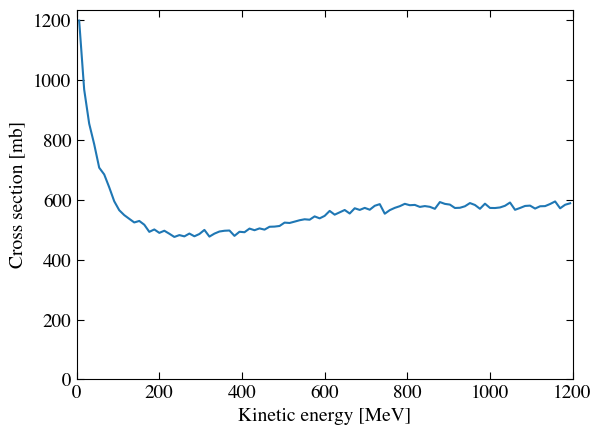

In [3]:
A = 40
r0 = 3*1.4
r = r0*(A**(1./3.))
scale_factor = 10*np.pi * r*r

KEbins = np.linspace(0, 1.2, 100)

# total inelastic
Nincident, _ = np.histogram(vars_p_hA18["ke"], bins=KEbins)
Ninteract, _ = np.histogram(vars_p_hA18["ke"][vars_p_hA18["probe_fsi"]>1], bins=KEbins)
plt.plot(1000*(KEbins[1:]+KEbins[:-1])/2, scale_factor*Ninteract/Nincident)
plt.xlim(0, 1200)
plt.xlabel("Kinetic energy [MeV]")
plt.ylim(0, None)
plt.ylabel("Cross section [mb]")
plt.show()

(array([9119669.,       0.,       0.,  657862.,       0.,       0.,
         145270.,       0.,       0.,   77199.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

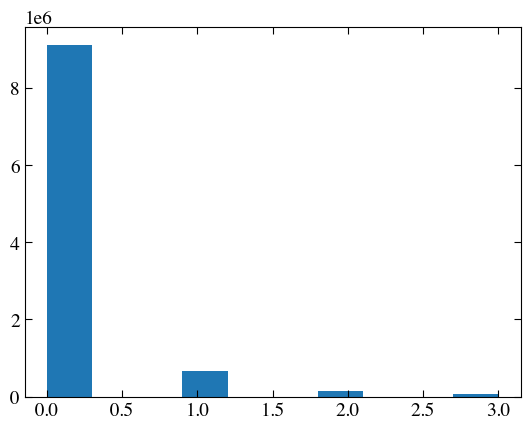

In [4]:
# interaction type
int_type_arr = []
for ievt in range(len(vars_p_hA18["probe_fsi"])):
    pdgh = vars_p_hA18["pdgh"][ievt]
    npip = np.count_nonzero(pdgh == 211)
    npim = np.count_nonzero(pdgh == -211)
    npic = npip + npim
    npi0 = np.count_nonzero(pdgh == 111)
    if vars_p_hA18["probe_fsi"][ievt] == 1:
        int_type_arr.append(0) # no interaction
    elif npic == 0 and npi0 == 0:
        int_type_arr.append(1) # no pion produced
    elif npic == 1 and npi0 == 0:
        int_type_arr.append(2) # a charged pion produced
    elif npic == 0 and npi0 == 1:
        int_type_arr.append(3) # a neutral pion produced
    else:
        int_type_arr.append(4) # more than one pion produced
int_type_arr = np.array(int_type_arr)
plt.hist(int_type_arr)